In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

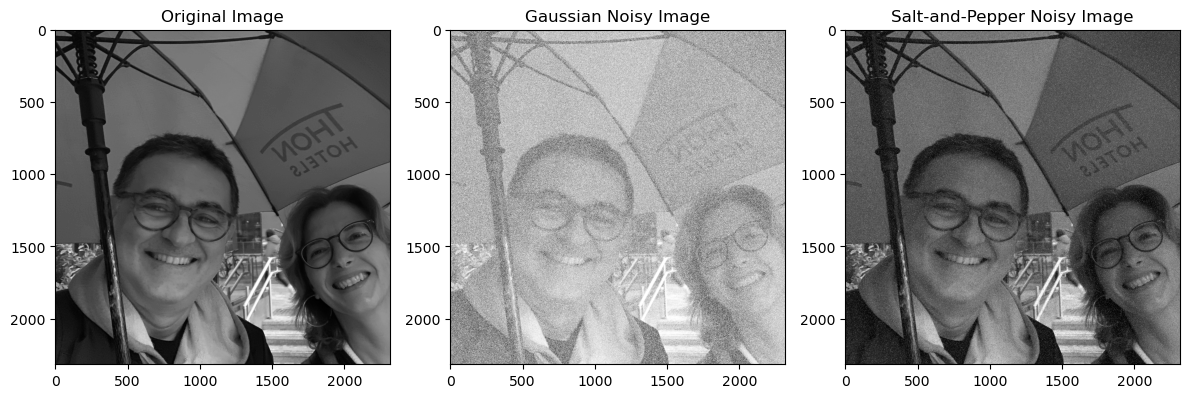

In [4]:
# Load an image from your computer
image_path = 'IMG_2691.jpg'  # Replace with the actual path
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Determine the size of the square matrix
n = min(img.shape)

# Take a square submatrix of size n from the image array
original_image = img[:n, :n]

# Add different types of noise (e.g., Gaussian, salt-and-pepper)
def add_gaussian_noise(image, mean=0, sigma=25):
    gaussian_noise = np.random.normal(mean, sigma, image.shape).astype('uint8')
    noisy_image = cv2.add(image, gaussian_noise)
    return noisy_image

def add_salt_and_pepper_noise(image, salt_prob=0.05, pepper_prob=0.05):
    noisy_image = np.copy(image)
    total_pixels = image.size

    # Add salt noise
    num_salt = np.ceil(salt_prob * total_pixels)
    salt_coords = [np.random.randint(0, i-1, int(num_salt)) for i in image.shape]
    noisy_image[salt_coords[0], salt_coords[1]] = 255

    # Add pepper noise
    num_pepper = np.ceil(pepper_prob * total_pixels)
    pepper_coords = [np.random.randint(0, i-1, int(num_pepper)) for i in image.shape]
    noisy_image[pepper_coords[0], pepper_coords[1]] = 0

    return noisy_image

# Add Gaussian noise
noisy_image_gaussian = add_gaussian_noise(original_image)

# Add salt-and-pepper noise
noisy_image_sp = add_salt_and_pepper_noise(original_image)

# Display the original and noisy images
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.title('Original Image')
plt.imshow(original_image, cmap='gray')

plt.subplot(132)
plt.title('Gaussian Noisy Image')
plt.imshow(noisy_image_gaussian, cmap='gray')

plt.subplot(133)
plt.title('Salt-and-Pepper Noisy Image')
plt.imshow(noisy_image_sp, cmap='gray')

plt.tight_layout()
plt.show()


In [5]:
import numpy as np

def generate_toeplitz_matrix(N):
    # Generate random values for the first row and column
    first_row = np.random.rand(N)
    first_column = np.random.rand(N)

    # Create the Toeplitz matrix
    toeplitz_matrix = np.zeros((N, N))
    for i in range(N):
        toeplitz_matrix[i, :] = np.roll(first_row, i)
        toeplitz_matrix[:, i] = np.roll(first_column, i)

    return toeplitz_matrix

def calculate_f_and_e1(a):
    n = len(a)
    first_column = a[:, 0]
    first_row = a[0, :]
    f = np.concatenate(([0], np.flip(first_column[1:]) - first_row[1:]))
    e1 = np.zeros(n)
    e1[0] = 1
    return f, e1

def solve_systems(T, f, e1):
    y = np.linalg.solve(T, e1)
    print(np.allclose(np.dot(T, y), e1))
    #x = np.linalg.solve(T.T, f - T @ y)
    x = np.linalg.solve(T,f)
    print(np.allclose(np.dot(T, x), f))
    return x, y

def generate_circulant_matrix(vec):
    n = len(vec)
    circulant_matrix = np.zeros((n, n))
    for i in range(n):
        circulant_matrix[i, :] = np.roll(vec, i)
    return circulant_matrix

def rearrange_vector(a):
    n = len(a)
    a_rearranged = np.zeros(n)
    a_rearranged[0] = a[0]
    a_rearranged[1:] = np.flip(a[1:])
    return a_rearranged

def generate_U1(x):
    n = len(x)
    U = np.tri(n, n, -1) + np.diag(np.ones(n))
    for i in range(n):
        U[i, i+1:] = -x[n-1:i:-1]
    return U

def generate_U2(x):
    n = len(x)
    U = np.zeros((n, n))
    for i in range(n):
        U[i, i+1:] = x[n-1:i:-1]
    return U


a = noisy_image_gaussian[0, :]

T = generate_toeplitz_matrix(2316)

print(a.shape)
print(noisy_image_gaussian.shape)

# Calculate f and e1
f, e1 = calculate_f_and_e1(T)

# Solve the systems
x, y = solve_systems(T, f, e1)
# Calculate T1, U1, T2, U2
T1 = generate_circulant_matrix(rearrange_vector(y)) #va amb y
U1 = generate_U1(x) #va amb x

T2 = generate_circulant_matrix(rearrange_vector(x))#va amb x
U2 = generate_U2(y) #va amb y

# Calculate the inverse matrix A^-1
A_inverse = T1 @ U1 + T2 @ U2

print(A_inverse.shape)


(2316,)
(2316, 2316)
True
True
(2316, 2316)


In [ ]:
from scipy.signal import fftconvolve

original_image = original_image.squeeze()

# Flip A_inverse for convolution
T_flipped = np.flipud(np.fliplr(T))

# Perform the convolution
conv_img = fftconvolve(original_image, T_flipped, mode='same')

# Display the denoised image
plt.imshow(conv_img, cmap='gray')
plt.show()

In [ ]:
# Flip A_inverse for convolution
A_inverse_flipped = np.flipud(np.fliplr(A_inverse))

# Perform the deconvolution
deconv_img = fftconvolve(original_image, A_inverse_flipped, mode='same')

# Display the denoised image
plt.imshow(deconv_img, cmap='gray')
plt.show()

True
True


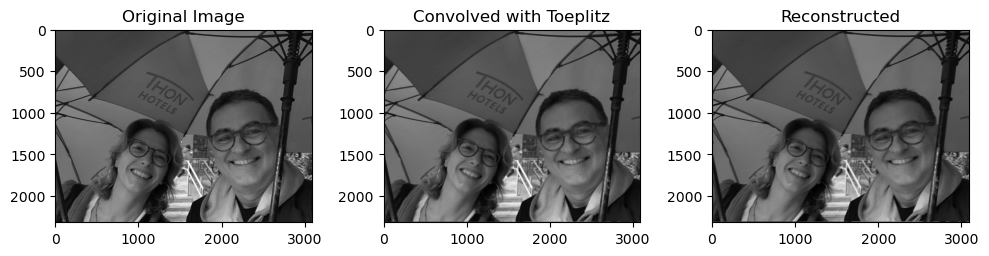

In [25]:
import numpy as np
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
from PIL import Image

def generate_toeplitz_matrix(N):
    first_row = np.random.rand(N)
    first_column = np.random.rand(N)
    toeplitz_matrix = np.zeros((N, N))
    for i in range(N):
        toeplitz_matrix[i, :] = np.roll(first_row, i)
        toeplitz_matrix[:, i] = np.roll(first_column, i)
    return toeplitz_matrix

def fft_convolve(image, kernel):
    fft_image = np.fft.fft2(image)
    fft_kernel = np.fft.fft2(kernel, s=image.shape)
    fft_result = fft_image * fft_kernel
    result = np.fft.ifft2(fft_result).real
    return result

# Load and convert an image to grayscale
image_path = "IMG_2691.jpg"  # Replace with your image path
original_image = Image.open(image_path).convert('L')
original_image = np.array(original_image)

# Define a Toeplitz matrix (for simplicity, we'll use a 3x3 matrix as an example)
toeplitz_matrix = generate_toeplitz_matrix(10)

# Flip the Toeplitz matrix and the original image before convolution
flipped_toeplitz_matrix = np.flipud(np.fliplr(toeplitz_matrix))

# Convolve the original image with the Toeplitz matrix using FFT
convolved_image = fft_convolve(original_image, flipped_toeplitz_matrix)

# Generate the inverse of the Toeplitz matrix
#inverse_toeplitz_matrix = np.linalg.inv(toeplitz_matrix)

# Calculate f and e1
f, e1 = calculate_f_and_e1(toeplitz_matrix)

# Solve the systems
x, y = solve_systems(toeplitz_matrix, f, e1)
# Calculate T1, U1, T2, U2
T1 = generate_circulant_matrix(rearrange_vector(y)) #va amb y
U1 = generate_U1(x) #va amb x

T2 = generate_circulant_matrix(rearrange_vector(x))#va amb x
U2 = generate_U2(y) #va amb y

# Calculate the inverse matrix A^-1
A_inverse = T1 @ U1 + T2 @ U2

#A_inverse = np.linalg.inv(toeplitz_matrix)

# Flip the inverse Toeplitz matrix before convolution
flipped_inverse_toeplitz_matrix = np.flipud(np.fliplr(A_inverse))

# Convolve the result with the inverse of the Toeplitz matrix using FFT
reconstructed_image = fft_convolve(convolved_image, flipped_inverse_toeplitz_matrix)

# Scale pixel values to the range [0, 255]
reconstructed_image = (reconstructed_image - reconstructed_image.min()) * (255 / (reconstructed_image.max() - reconstructed_image.min()))

# Display the images
plt.figure(figsize=(10, 4))

plt.subplot(131)
plt.title('Original Image')
plt.imshow(np.flipud(original_image), cmap='gray')

plt.subplot(132)
plt.title('Convolved with Toeplitz')
plt.imshow(np.flipud(convolved_image), cmap='gray')

plt.subplot(133)
plt.title('Reconstructed')
plt.imshow(np.flipud(reconstructed_image), cmap='gray')

plt.tight_layout()
plt.show()
